## Dependencias 

In [141]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats 
from varclushi import VarClusHi
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from CreditScoringToolkit.frequency_table import frequency_table
from CreditScoringToolkit.DiscreteNormalizer import DiscreteNormalizer
from CreditScoringToolkit.WoeEncoder import WoeEncoder
from CreditScoringToolkit.WoeContinuousFeatureSelector import WoeContinuousFeatureSelector
from CreditScoringToolkit.WoeDiscreteFeatureSelector import WoeDiscreteFeatureSelector
from CreditScoringToolkit.CreditScoring import CreditScoring


import warnings
warnings.filterwarnings('ignore')

## Cargar Datos

In [142]:
data = pd.read_csv('../data/churn_taxi.zip')
data.shape

(1438874, 13)

In [143]:
data.head()

,id_taxi,fh_mes,d_debajo_prom_ing,c_ticket_prom,c_num_meses_activo,c_prom_ing_mes_c_prop,c_prom_ing_mes_s_prop,c_pct_viajes_malos,c_distancia_promedio,d_empresa,c_pct_cash,fuga,d_mes
0,1,2015-03-01,True,41.118113,5,363.210000,361.210000,0.094340,0.00000,OTRA,0.000000,0,3
1,1,2015-05-01,True,41.621228,6,395.401667,392.235000,0.122807,0.00000,OTRA,0.000000,0,5
2,1,2015-11-01,True,50.869524,4,356.086667,318.743333,0.054545,0.00000,OTRA,0.000000,0,11
3,1,2015-12-01,True,50.421961,5,428.586667,391.243333,0.018182,0.00000,OTRA,0.000000,0,12
4,1,2016-01-01,True,23.660963,6,532.371667,465.310000,0.607407,3.57963,OTRA,0.407898,1,1


## Partición

In [144]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((1007211, 13), (431663, 13))

In [145]:
full = train.copy()
train = train.sample(5000, random_state=42).reset_index(drop=True)

## Naturaleza de variables 

In [146]:
um = ['id_taxi','fh_mes']
varc = [v for v in data.columns if v[:2]=='c_']
vard = [v for v in data.columns if v[:2]=='d_']
vart = ['fuga']
len(varc),len(vard)

(7, 3)

In [ ]:
# Validación de representatividad de la muestra
for v in varc:
    print(v, stats.ks_2samp(train[v].dropna(), full[v].dropna()).statistic)

c_ticket_prom 0.011287350316865119
c_num_meses_activo 0.01089870225801745
c_prom_ing_mes_c_prop 0.018583002171342455
c_prom_ing_mes_s_prop 0.017234965265470692
c_pct_viajes_malos 0.011354999275264621
c_distancia_promedio 0.01316878016213352
c_pct_cash 0.009508837762196465


## Análisis Exploratorio de datos 

### Continuo 

#### Ausentes

In [147]:
train[varc].isna().sum()/len(train)

c_ticket_prom            0.0000
c_num_meses_activo       0.0000
c_prom_ing_mes_c_prop    0.0000
c_prom_ing_mes_s_prop    0.0000
c_pct_viajes_malos       0.0192
c_distancia_promedio     0.0192
c_pct_cash               0.0194
dtype: float64

In [148]:
im = SimpleImputer(strategy='median')

In [149]:
im.fit(train[varc])

SimpleImputer(strategy='median')

In [150]:
Xt = train[um+varc].copy()

In [151]:
Xt[varc] = im.transform(Xt[varc])

In [152]:
Xt.dropna().shape,Xt.shape

((5000, 9), (5000, 9))

In [153]:
for v in varc:
    print(v,stats.ks_2samp(train[v].dropna(),Xt[v]).statistic)


c_ticket_prom 0.0
c_num_meses_activo 0.0
c_prom_ing_mes_c_prop 0.0
c_prom_ing_mes_s_prop 0.0
c_pct_viajes_malos 0.0096
c_distancia_promedio 0.0096
c_pct_cash 0.009698021619416684


#### Multicolinealidad 

In [154]:
vc = VarClusHi(Xt,feat_list=varc).varclus()
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
mc

['c_pct_viajes_malos', 'c_prom_ing_mes_c_prop']

#### Extremos

array([[<Axes: title={'center': 'c_pct_viajes_malos'}>,
        <Axes: title={'center': 'c_prom_ing_mes_c_prop'}>]], dtype=object)

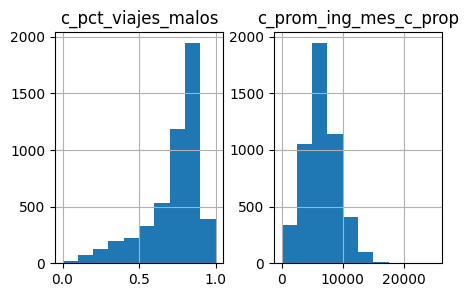

In [155]:
Xt[mc].hist(figsize=(5,3))

In [156]:
for v,li,ls in Xt[mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xt[f'ex_{v}'] =((Xt[v]<li)|(Xt[v]>ls)).astype(int)
Xt['ex_'] = Xt[[f'ex_{v}' for v in mc]].max(axis=1)

In [157]:
frequency_table(Xt,'ex_')

****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0          4818      0.9636              4818            0.9636
1           182      0.0364              5000            1.0000






In [158]:
Xt = Xt.loc[Xt['ex_']==0].reset_index(drop=True)
Xt.drop(columns=[f'ex_{v}' for v in mc]+['ex_'],inplace=True)

array([[<Axes: title={'center': 'c_pct_viajes_malos'}>,
        <Axes: title={'center': 'c_prom_ing_mes_c_prop'}>]], dtype=object)

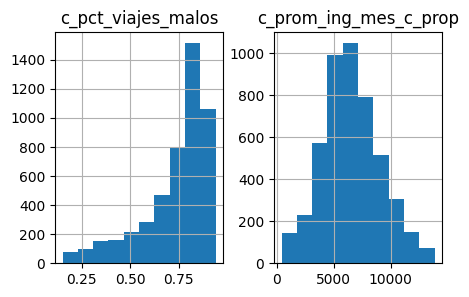

In [159]:
Xt[mc].hist(figsize=(5,3))

### Discreto 

In [160]:
for v in vard:
    train[v] = train[v].fillna('MISSING')

In [161]:
frequency_table(train,vard)

****Frequency Table  d_debajo_prom_ing  ***


                   Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
d_debajo_prom_ing                                                            
False                    2691      0.5382              2691            0.5382
True                     2309      0.4618              5000            1.0000




****Frequency Table  d_empresa  ***


           Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
d_empresa                                                            
E117              202      0.0404               202            0.0404
E122              242      0.0484               444            0.0888
E125              275      0.0550               719            0.1438
E131              185      0.0370               904            0.1808
E133              189      0.0378              1093            0.2186
E135              148      0.0296              1241            0.2482
E137              500      0.1000       

#### Normalize discrete variables

In [162]:
dn = DiscreteNormalizer(normalization_threshold=0.05,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xtn = dn.transform(train[vard])
Xtn[um] = train[um]
frequency_table(Xtn,vard)

****Frequency Table  d_debajo_prom_ing  ***


                   Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
d_debajo_prom_ing                                                            
False                    2691      0.5382              2691            0.5382
True                     2309      0.4618              5000            1.0000




****Frequency Table  d_empresa  ***


                  Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
d_empresa                                                                   
E125                     275      0.0550               275            0.0550
E137                     500      0.1000               775            0.1550
E167                    1072      0.2144              1847            0.3694
OTRA                    1380      0.2760              3227            0.6454
SMALL CATEGORIES        1773      0.3546              5000            1.0000




****Frequency Table  d_mes  ***


       Abs. Freq.  Rel.

In [163]:
unary = [v for v in vard if Xtn[v].nunique()==1]
unary

[]

In [164]:
vard = [v for v in vard if v not in unary]

In [165]:
#Merge continuous features matrix with the normalized discrete predictors Matrix
Xt = Xt.merge(Xtn, on=um, how='inner').merge(train[um+vart],on=um,how='inner')[um+mc+vard+vart]
Xt.head()

,id_taxi,fh_mes,c_pct_viajes_malos,c_prom_ing_mes_c_prop,d_debajo_prom_ing,d_empresa,d_mes,fuga
0,4820,2019-05-01,0.644162,10184.348333,False,E137,5,0
1,834,2016-03-01,0.868954,11545.965000,False,SMALL CATEGORIES,3,0
2,5464,2014-12-01,0.881894,3874.758333,True,OTRA,12,0
3,5382,2022-09-01,0.374276,10167.900000,False,E137,9,0
4,3354,2022-01-01,0.848237,4315.906667,True,E167,1,0


In [166]:
frequency_table(Xt,vart)

****Frequency Table  fuga  ***


      Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
fuga                                                            
0           4746    0.964634              4746          0.964634
1            174    0.035366              4920          1.000000






In [167]:
wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[mc],Xt[vart[0]],
        max_bins=6,
        strictly_monotonic=True,
        iv_threshold=0.1,
        method='dcc',
        n_threads=20)

wdf.fit(Xt[vard],Xt[vart[0]],iv_threshold=0.1)


In [168]:
#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[mc]),Xt[um+vart]],axis=1)

features = [v for v in Xt.columns if v not in um+vart]

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

Best continuous features:  [{'feature': 'disc_c_pct_viajes_malos_2_quantile', 'iv': 0.12791940844902072, 'root_feature': 'c_pct_viajes_malos', 'nbins': '2', 'method': 'quantile'}, {'feature': 'disc_c_prom_ing_mes_c_prop_5_quantile', 'iv': 0.5271417380589063, 'root_feature': 'c_prom_ing_mes_c_prop', 'nbins': '5', 'method': 'quantile'}]
Best discrete features:  {'d_debajo_prom_ing': 0.4066223144407105, 'd_empresa': 0.20458635878940917, 'd_mes': 0.4256063958129421}
Best Features selected:  ['d_debajo_prom_ing', 'd_empresa', 'd_mes', 'disc_c_pct_viajes_malos_2_quantile', 'disc_c_prom_ing_mes_c_prop_5_quantile']


In [169]:
pd.DataFrame(wcf.selected_features)

,feature,iv,root_feature,nbins,method
0,disc_c_pct_viajes_malos_2_quantile,0.127919,c_pct_viajes_malos,2,quantile
1,disc_c_prom_ing_mes_c_prop_5_quantile,0.527142,c_prom_ing_mes_c_prop,5,quantile


In [170]:
wdf.selected_features

{'d_debajo_prom_ing': 0.4066223144407105,
 'd_empresa': 0.20458635878940917,
 'd_mes': 0.4256063958129421}

## WoE Transformation

In [171]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],Xt[vart[0]])
Xwt = we.transform(Xt[features])
Xwt.head()

,d_debajo_prom_ing,d_empresa,d_mes,disc_c_pct_viajes_malos_2_quantile,disc_c_prom_ing_mes_c_prop_5_quantile
0,0.806015,-0.076655,0.037131,-0.298057,1.088447
1,0.806015,-0.385233,-0.943932,0.433791,1.088447
2,-0.522028,0.099064,-1.013467,0.433791,-0.853672
3,0.806015,-0.076655,0.635580,-0.298057,1.088447
4,-0.522028,0.636550,0.114453,0.433791,-0.853672


## Aprendizaje con regresión logística

In [172]:
lr = LogisticRegression()
lr.fit(Xwt,Xt[vart[0]])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=Xt[vart[0]]))

AUC for training:  0.7976614305573719


In [173]:
lr.coef_,lr.intercept_

(array([[-0.0345715 , -1.11702903, -1.00808496, -0.94132841, -1.003007  ]]),
 array([-3.29703562]))

## Scoring 

In [174]:
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

points
feature                               attribute                   
d_debajo_prom_ing                     False                     61
                                      True                      60
d_empresa                             E125                     112
                                      E137                      58
                                      E167                      81
                                      OTRA                      64
                                      SMALL CATEGORIES          48
d_mes                                 1                         64
                                      10                        88
                                      11                        60
                                      12                        31
                                      2                         68
                                      3                         33
                                      4                         64
                                      5                         62
                                      6                         85
                                      7                         83
                                      8                         68
                                      9                         79
disc_c_pct_viajes_malos_2_quantile    (-inf, 0.792]             52
                                      (0.792, inf]              72
disc_c_prom_ing_mes_c_prop_5_quantile (-inf, 4483.359]          36
                                      (4483.359, 5768.45]       52
                                      (5768.45, 7025.079]       72
                                      (7025.079, 8653.123]      87
                                      (8653.123, inf]           92

In [182]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting

for v in vard:
    valid[v] = valid[v].fillna('MISSING')
valid[varc]  = im.transform(valid[varc])

Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[mc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid[vart[0]]))

AUC for validation:  0.800817037981429


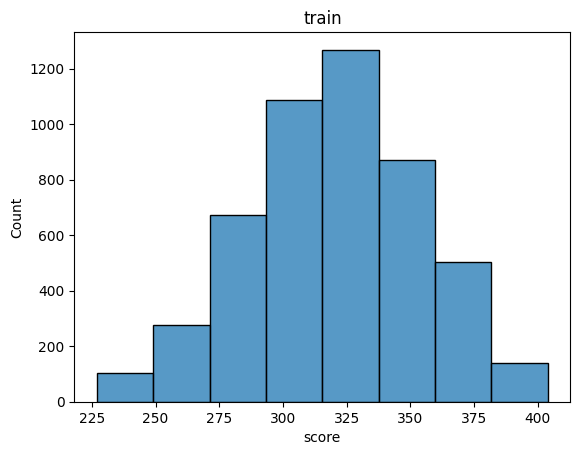

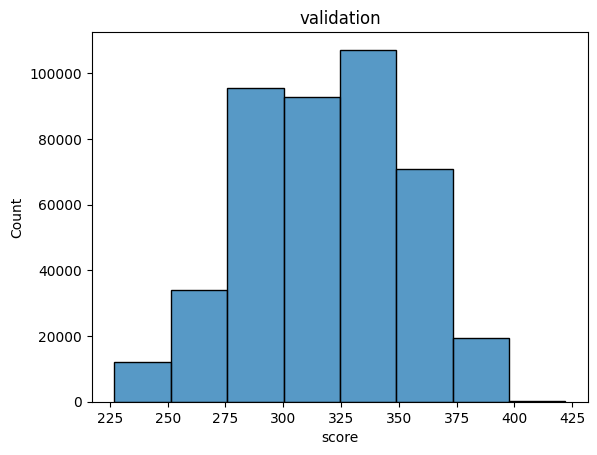

In [183]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid[vart[0]]],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),Xt[vart[0]]],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

<Figure size 640x480 with 0 Axes>

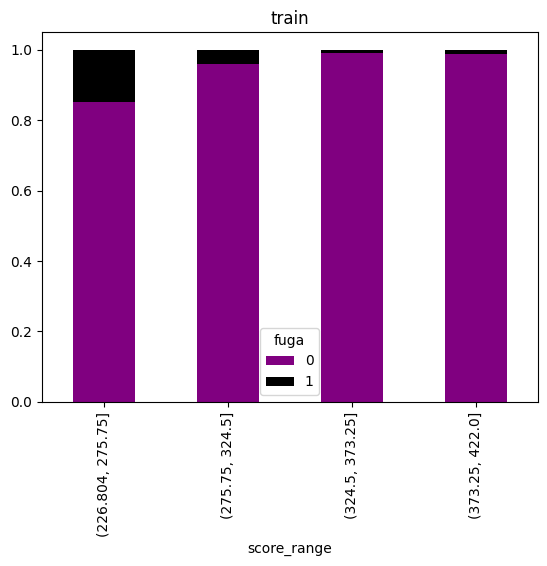

<Figure size 640x480 with 0 Axes>

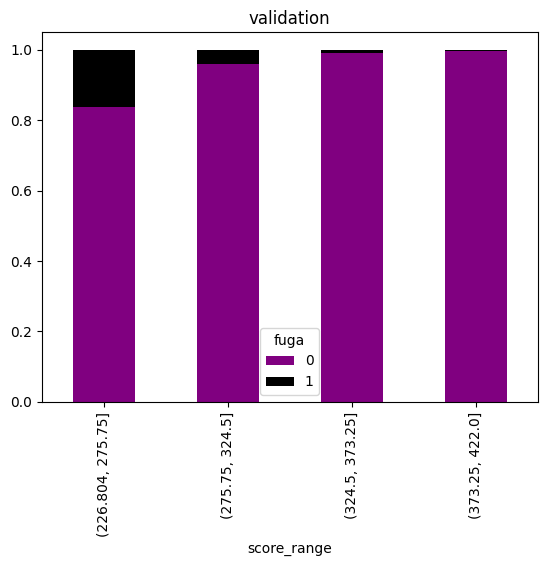

In [185]:
#   Finally, we can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=4,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index=vart[0],
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)

In [186]:
score['score_range'] = pd.cut(score['score'],bins=4,include_lowest=True).astype(str)

In [187]:
score.groupby(['score_range',vart[0],'sample']).count().to_clipboard()

In [188]:
cs.pdo,cs.offset,cs.base_score

(20, np.float64(400.0), 400)